### Fleet EDA: Post-Run Analysis
1. Setup & Connection

In [23]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.oauth2 import service_account

KEY_PATH = os.path.join('..', 'service_account.json')

if not os.path.exists(KEY_PATH):
    raise FileNotFoundError(f"Key not found at {os.path.abspath(KEY_PATH)}. Check file location!")

# Authenticate
credentials = service_account.Credentials.from_service_account_file(KEY_PATH)
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

print(f"Connected to BigQuery Project: {credentials.project_id}")
# Load Data
df_alerts = client.query("SELECT * FROM `fleet_intel_staging.alerts_slack`").to_dataframe()
print(f"Data Loaded: {len(df_alerts)} rows.")
df_alerts.head()

Connected to BigQuery Project: fleetintel360


/opt/anaconda3/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Data Loaded: 39 rows.


,vehicle_id,driver_id,severity,alert_message,alert_time
0,BUS_10,DR_010,CRITICAL,FINANCE: Fraud detected for DR_010,2026-01-31 13:01:08.632733+00:00
1,BUS_16,DR_016,CRITICAL,FATIGUE: High Risk Driver (DR_016),2026-01-31 13:01:08.632733+00:00
2,BUS_12,DR_012,CRITICAL,FINANCE: Fraud detected for DR_012,2026-01-31 13:01:08.632733+00:00
3,CAR_03,DR_028,CRITICAL,FINANCE: Fraud detected for DR_028,2026-01-31 13:01:08.632733+00:00
4,CAR_04,DR_029,CRITICAL,FATIGUE: High Risk Driver (DR_029),2026-01-31 13:01:08.632733+00:00


2. Risk Distribution (The "Why")

/var/folders/_j/vh40_m850sz_s5l6tdwvy29h0000gn/T/ipykernel_19807/97478996.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_alerts, x='category', palette='viridis')


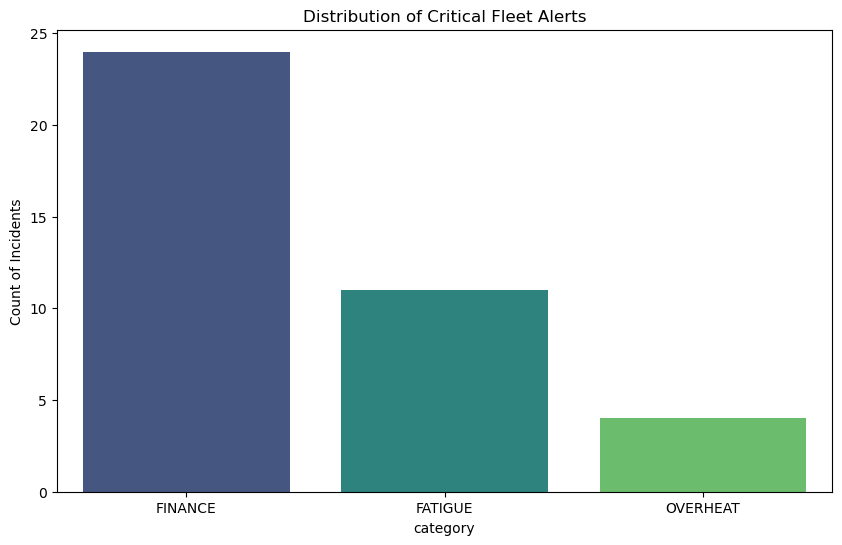

In [24]:
# Extract the Category from the alert_message string
df_alerts['category'] = df_alerts['alert_message'].str.split(':').str[0]

plt.figure(figsize=(10, 6))
sns.countplot(data=df_alerts, x='category', palette='viridis')
plt.title('Distribution of Critical Fleet Alerts')
plt.ylabel('Count of Incidents')
plt.show()

3. Risk Correlation: Speeding vs. Overheating

/opt/anaconda3/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


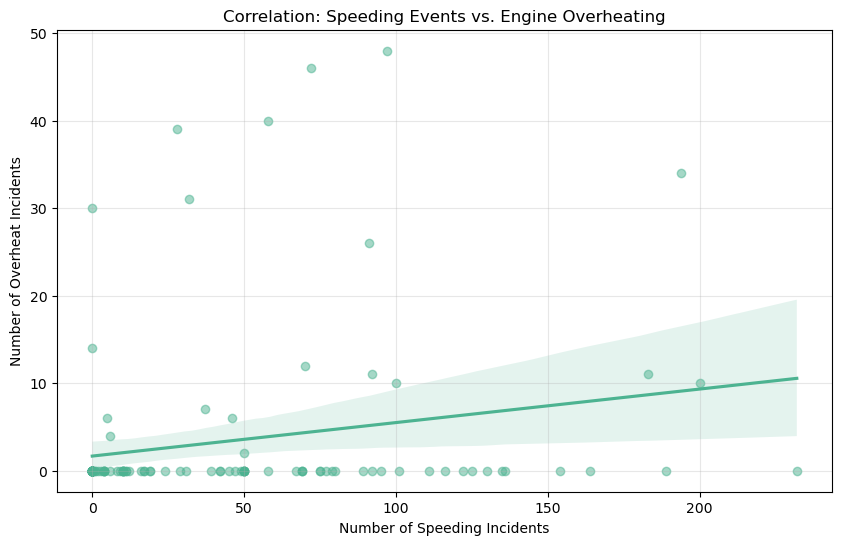

In [25]:
query_performance = """
    SELECT speeding_events, overheat_events, driver_name, vehicle_id
    FROM `fleet_intel_staging.fct_fleet_performance`
"""
df_perf = client.query(query_performance).to_dataframe()

plt.figure(figsize=(10, 6))
# Using a regression plot to see if there's a trend
sns.regplot(data=df_perf, x='speeding_events', y='overheat_events', scatter_kws={'alpha':0.5}, color='#4CB391')
plt.title('Correlation: Speeding Events vs. Engine Overheating')
plt.xlabel('Number of Speeding Incidents')
plt.ylabel('Number of Overheat Incidents')
plt.grid(True, alpha=0.3)
plt.show()